# 2. 서울시 범죄 현황 분석
<분석 목적>
- 부유층이 많이 사는 강남 3구(강남, 서초, 송파)의 체감 안전도가 정말로 높은지를 검증해보고자 한다
    - "강남 3구(강남, 서초, 송파)의 체감 안전도" 관련 뉴스 기사: https://www.news1.kr/articles/?1911504

<데이터 설명>
- 1. 서울시 관서별 5대 범죄 발생 검거 현황 데이터: "02. crime_in_Seoul.csv"
    - *서울시 경찰서 별로 살인, 강도, 강간, 절도, 폭력이라는 5대 범죄에 대한 발생 건수 및 검거 건수*
    - 관서명: 중부서, 종로서, 남대문서, ...
    - 살인 발생: 살인 사건 발생 건수
    - 살인 검거: 살인 용의자 검거 건수
    - 강도 발생: 강도 사건 발생 건수
    - 강도 검거: 강도 용의자 검거 건수
    - 강간 발생: 강간 사건 발생 건수
    - 강간 검거: 강간 용의자 검거 건수
    - 절도 발생: 절도 사건 발생 건수
    - 절도 검거: 절도 용의자 검거 건수
    - 폭력 발생: 폭력 사건 발생 건수
    - 폭력 검거: 폭력 용의자 검거 건수

In [4]:
import numpy as np
import pandas as pd

## 데이터 정리하기

**다운 받은 데이터가 관서별(경찰서별)로 되어있다**
- 서울시에는 한 구에 하나 또는 두 군데의 경찰서가 위치하고 있으며, 구 이름과 다른 경찰서도 존재한다
- 경찰서 목록을 소속 구별로 변경해주어야 할 것 같다

In [5]:
# 콤마(,)로 천 단위가 구분되어 있으므로, thousands = ','로 설정
# 한글 인코딩이므로, encoding = 'euc-kr'로 설정
crime_anal_police = pd.read_csv("../data/02. crime_in_Seoul.csv", thousands = ',',
                                encoding = 'euc-kr')
crime_anal_police.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/02. crime_in_Seoul.csv'

**경찰서 이름으로 구 정보를 파악해야 한다**
- 양이 많지 않아서 아래의 사이트를 참고하면서, 직접 수작업으로 해줘도 되긴 한다...그런데 굳이? 그럴 필요는 없어보인다. 왜냐하면 우리에겐 구글 맵스가 있기 때문이다! ^^
    - <위키백과 서울시 관서별 경찰서 목록 사이트>:
    https://ko.wikipedia.org/wiki/%EB%B6%84%EB%A5%98:%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C%EC%9D%98_%EA%B2%BD%EC%B0%B0%EC%84%9C
- 구글 맵스를 사용해서 경찰서의 위치(위도, 경도) 정보를 받아온다
    - 구글 지도 API가 유료화된 관계로 아래에 첨부된 사이트를 참고해서 API 키를 받아오자 --> https://pinkwink.kr/1143
    - API 키를 받아왔다면, cmd 창을 켜서 ```pip install googlemaps``` 명령문으로 googlemaps 모듈을 설치하자!!

In [ ]:
import googlemaps

In [ ]:
# gmaps_key에 구글 지도 API 키 값을 넣어준다
gmaps_key = "**********************************"
gmaps = googlemaps.Client(key = gmaps_key)

**Google Maps를 사용한 단어 검색**
- 'formatted_address' 항목에 '주소'가 출력
- 'lng'와 'lat'에 '위도'와 '경도' 정보가 출력
- 추후에 지도 시각화에서 유용하게 사용할 수 있는 정보!!

In [ ]:
a = gmaps.geocode('서울중부경찰서', language = 'ko')
b = a[0].get("geometry")
b['location']['lng']

126.9895796

In [ ]:
gmaps.geocode('서울중부경찰서', language = 'ko')

[{'access_points': [],
  'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '을지로동',
    'short_name': '을지로동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 을지로동 수표로 27',
  'geometry': {'location': {'lat': 37.5636465, 'lng': 126.9895796},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.56499548029149,
     'lng': 126.9909285802915},
   

**crime_anal_police 데이터의 '관서명' 형태 변경**
- 구글 검색에서 주소가 제대로 나오게끔 해주기 위해,
- 'OO서(ex. 중부서)'의 형태인 '관서명'을 '서울OO경찰서(ex. 서울중부경찰서)'의 형태로 변경

In [ ]:
station_name = []

for name in crime_anal_police['관서명']:
    # '중부서', '수서서', ... 을 '서울중부경찰서', '서울수서경찰서', ... 의 형태로 변경 
    station_name.append('서울' + str(name[:-1]) + '경찰서')
    
station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

**각 경찰서별로 주소, 위도, 경도 데이터를 추출하기**

In [ ]:
station_address = [] # 주소
station_lat = [] # 위도
station_lng = [] # 경도

# for문을 사용해서, 각 경찰서 별로 아래의 작업을 수행
for name in station_name:
    tmp = gmaps.geocode(name, language = 'ko')
    
    # 주소(address) 정보를 담고 있는 "formatted_address" 추출
    station_address.append(tmp[0].get("formatted_address"))
    
    # 위도(lat) 및 경도(lng)의 정보를 담고 있는 "geometry" 추출
    tmp_loc = tmp[0].get("geometry")
    
    station_lat.append(tmp_loc['location']['lat'])
    station_lng.append(tmp_loc['location']['lng'])
    
    print(name + '-->' + tmp[0].get("formatted_address"))

서울중부경찰서-->대한민국 서울특별시 중구 을지로동 수표로 27
서울종로경찰서-->대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46
서울남대문경찰서-->대한민국 서울특별시 중구 회현동 한강대로 410
서울서대문경찰서-->대한민국 서울특별시 서대문구 충현동 통일로 113
서울혜화경찰서-->대한민국 서울특별시 종로구 인의동 창경궁로 112-16
서울용산경찰서-->대한민국 서울특별시 용산구 원효로1가 백범로 329
서울성북경찰서-->대한민국 서울특별시 성북구 삼선동5가 301
서울동대문경찰서-->대한민국 서울특별시 동대문구 청량리동 약령시로21길 29
서울마포경찰서-->대한민국 서울특별시 마포구 아현동 마포대로 183
서울영등포경찰서-->대한민국 서울특별시 영등포구 영등포동1가 618-7
서울성동경찰서-->대한민국 서울특별시 성동구 행당동 왕십리광장로 9
서울동작경찰서-->대한민국 서울특별시 동작구 노량진1동 노량진로 148
서울광진경찰서-->대한민국 서울특별시 광진구 구의동 자양로 167
서울서부경찰서-->대한민국 서울특별시 은평구 대조동 통일로 757
서울강북경찰서-->대한민국 서울특별시 강북구 번1동 오패산로 406
서울금천경찰서-->대한민국 서울특별시 금천구 시흥동 190
서울중랑경찰서-->대한민국 서울특별시 중랑구 묵동 120
서울강남경찰서-->대한민국 서울특별시 강남구 대치동 998
서울관악경찰서-->대한민국 서울특별시 관악구 봉천동
서울강서경찰서-->대한민국 서울특별시 강서구 화곡6동 980-15
서울강동경찰서-->대한민국 서울특별시 강동구 성내1동 성내로 57
서울종암경찰서-->대한민국 서울특별시 성북구 종암동 종암로 135
서울구로경찰서-->대한민국 서울특별시 구로구 구로동 가마산로 235
서울서초경찰서-->대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서-->대한민국 서울특별시 양천구 신정6동 목동동로 99
서울송파경찰서-->대한민국 서울특별시 송파구 가락본동 9
서울노원경찰서-->대한민국 서울특별시 노원구 하계동 노원로

**1. 각 경찰서의 주소**

In [ ]:
station_address

['대한민국 서울특별시 중구 을지로동 수표로 27',
 '대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46',
 '대한민국 서울특별시 중구 회현동 한강대로 410',
 '대한민국 서울특별시 서대문구 충현동 통일로 113',
 '대한민국 서울특별시 종로구 인의동 창경궁로 112-16',
 '대한민국 서울특별시 용산구 원효로1가 백범로 329',
 '대한민국 서울특별시 성북구 삼선동5가 301',
 '대한민국 서울특별시 동대문구 청량리동 약령시로21길 29',
 '대한민국 서울특별시 마포구 아현동 마포대로 183',
 '대한민국 서울특별시 영등포구 영등포동1가 618-7',
 '대한민국 서울특별시 성동구 행당동 왕십리광장로 9',
 '대한민국 서울특별시 동작구 노량진1동 노량진로 148',
 '대한민국 서울특별시 광진구 구의동 자양로 167',
 '대한민국 서울특별시 은평구 대조동 통일로 757',
 '대한민국 서울특별시 강북구 번1동 오패산로 406',
 '대한민국 서울특별시 금천구 시흥동 190',
 '대한민국 서울특별시 중랑구 묵동 120',
 '대한민국 서울특별시 강남구 대치동 998',
 '대한민국 서울특별시 관악구 봉천동',
 '대한민국 서울특별시 강서구 화곡6동 980-15',
 '대한민국 서울특별시 강동구 성내1동 성내로 57',
 '대한민국 서울특별시 성북구 종암동 종암로 135',
 '대한민국 서울특별시 구로구 구로동 가마산로 235',
 '대한민국 서울특별시 서초구 서초3동 반포대로 179',
 '대한민국 서울특별시 양천구 신정6동 목동동로 99',
 '대한민국 서울특별시 송파구 가락본동 9',
 '대한민국 서울특별시 노원구 하계동 노원로 283',
 '대한민국 서울특별시 서초구 방배본동 동작대로 204',
 '대한민국 서울특별시 은평구 불광동 연서로 365',
 '대한민국 서울특별시 도봉구 창4동 노해로 403',
 '대한민국 서울특별시 강남구 개포동 개포로 617']

**2. 각 경찰서의 위도**

In [ ]:
station_lat

[37.5636465,
 37.5755578,
 37.5547584,
 37.5647848,
 37.5718529,
 37.5387099,
 37.5897482,
 37.58506149999999,
 37.550814,
 37.5153176,
 37.5617309,
 37.5130866,
 37.542873,
 37.6128611,
 37.63730390000001,
 37.4568722,
 37.6145819,
 37.5094352,
 37.4743789,
 37.5516732,
 37.528511,
 37.6020592,
 37.494931,
 37.4956054,
 37.5165667,
 37.5019065,
 37.6425238,
 37.4945959,
 37.6283597,
 37.6533589,
 37.49349]

**3. 각 경찰서의 경도**

In [ ]:
station_lng

[126.9895796,
 126.9848674,
 126.9734981,
 126.9667762,
 126.9989143,
 126.9659183,
 127.0161353,
 127.0457679,
 126.954028,
 126.905728,
 127.0363806,
 126.9428498,
 127.083821,
 126.9274951,
 127.0273399,
 126.8970429,
 127.0815539,
 127.0669578,
 126.9509748,
 126.8499269,
 127.1268224,
 127.0321577,
 126.886731,
 127.0052504,
 126.8656763,
 127.1271513,
 127.0717076,
 126.9831279,
 126.9287226,
 127.052682,
 127.0772119]

In [ ]:
gu_name = []

for name in station_address:
    tmp = name.split() # 공백을 기준으로 분할
    
    # 두 번째 단어('구' 이름)를 선택
    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]
    
    gu_name.append(tmp_gu)
    
crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


**교재 출판 당시에는 '서울금천경찰서'가 '관악구'에 위치해 있어서 '금천서'는 예외 처리를 해줘야만 했다**

**그러나 2018년 '서울금천경찰서'가 '금천구' 관내로 이전하면서, 데이터 또한 update 되었다. 따라서 예외 처리 불필요!!**

In [ ]:
# 실제로 데이터가 잘 update 되었는지 확인해보자
crime_anal_police[crime_anal_police['관서명'] == '금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,금천구


**위의 과정들을 거쳐 만들어진 crime_anal_police 데이터를, csv 파일로 내보내는 코드는 따로 실행하지 않겠다**

**(이미 data 폴더에 해당 데이터가 존재하기 때문)**

In [ ]:
# crime_anal_police.to_csv(../data/02. crime_in_Seoul_include_gu_name.csv',
#                          sep = ',', encoding = 'utf-8')

**데이터 처리 작업을 '관서명'을 기준으로 수행해주었기 때문에, '구별' 컬럼에는 아래와 같이 중복 값이 존재!!**

**즉, 같은 '구' 이름이 두 번 있을 수 있다는 말**

In [ ]:
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


## [참고] pandas의 pivot_table 익히기
- "crime_in_Seoul_include_gu_name.csv" 데이터를 정리해주기에 앞서, ```pandas```의 ```pivot_table```에 대해 간략하게 학습해본다
- 참고자료 출처: https://github.com/chris1610/pbpython/tree/master/data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel("../data/02. sales-funnel.xlsx")
df.head()

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Account   17 non-null     int64 
 1   Name      17 non-null     object
 2   Rep       17 non-null     object
 3   Manager   17 non-null     object
 4   Product   17 non-null     object
 5   Quantity  17 non-null     int64 
 6   Price     17 non-null     int64 
 7   Status    17 non-null     object
dtypes: int64(3), object(5)
memory usage: 1.2+ KB


**위 데이터에서 'Name' 항목으로만 정렬**
- 'Name' 컬럼이 index가 되고, 특별히 다른 파라미터들을 지정하지 않았다면 '숫자형' 데이터 컬럼들(Account, Price, Quantity)만 출력된다
- 또한 중복된 'Name'의 항목은 하나로 합쳐지고 Account, Price, Quantity 각각의 값들은 '평균 값'을 갖는다

In [ ]:
pd.pivot_table(df, index = ['Name'])

,Account,Price,Quantity
Name,,,
Barton LLC,740150,35000,1.000000
"Fritsch, Russel and Anderson",737550,35000,1.000000
Herman LLC,141962,65000,2.000000
Jerde-Hilpert,412290,5000,2.000000
"Kassulke, Ondricka and Metz",307599,7000,3.000000
Keeling LLC,688981,100000,5.000000
Kiehn-Spinka,146832,65000,2.000000
Koepp Ltd,729833,35000,2.000000
Kulas Inc,218895,25000,1.500000


**```index```를 여러 개 지정('Name', 'Rep', 'Manager')**

In [ ]:
pd.pivot_table(df, index = ['Name', 'Rep', 'Manager'])

,,,Account,Price,Quantity
Name,Rep,Manager,,,
Barton LLC,John Smith,Debra Henley,740150,35000,1.000000
"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,737550,35000,1.000000
Herman LLC,Cedric Moss,Fred Anderson,141962,65000,2.000000
Jerde-Hilpert,John Smith,Debra Henley,412290,5000,2.000000
"Kassulke, Ondricka and Metz",Wendy Yule,Fred Anderson,307599,7000,3.000000
Keeling LLC,Wendy Yule,Fred Anderson,688981,100000,5.000000
Kiehn-Spinka,Daniel Hilton,Debra Henley,146832,65000,2.000000
Koepp Ltd,Wendy Yule,Fred Anderson,729833,35000,2.000000
Kulas Inc,Daniel Hilton,Debra Henley,218895,25000,1.500000


**특정 값(value)만 지정**
- value를 pivot_table로 합친 경우, '평균치'가 기본이 된다
- 특정 값(들)만 지정해주고 싶은 경우, ```values``` 옵션을 사용하면 된다
- ex) Price 값만 지정

In [ ]:
pd.pivot_table(df, index = ['Manager', 'Rep'], values = ['Price'])

Price
Manager       Rep                        
Debra Henley  Craig Booker   20000.000000
              Daniel Hilton  38333.333333
              John Smith     20000.000000
Fred Anderson Cedric Moss    27500.000000
              Wendy Yule     44250.000000

**value를 '평균치'가 아닌 '합계'를 사용하고자 한다면, ```aggfunc``` 옵션에 ```np.sum``` 을 사용!!**

In [ ]:
pd.pivot_table(df, index = ['Manager', 'Rep'], values = ['Price'], aggfunc = np.sum)

Price
Manager       Rep                  
Debra Henley  Craig Booker    80000
              Daniel Hilton  115000
              John Smith      40000
Fred Anderson Cedric Moss    110000
              Wendy Yule     177000

**value로 '평균치'와 '데이터의 갯수'를 사용하고자 한다면, ```aggfunc``` 옵션에 ```np.mean``` 과 ```len``` 을 사용!!**

In [ ]:
pd.pivot_table(df, index = ['Manager', 'Rep'], values = ['Price'], aggfunc = [np.mean, len])

mean   len
                                    Price Price
Manager       Rep                              
Debra Henley  Craig Booker   20000.000000     4
              Daniel Hilton  38333.333333     3
              John Smith     20000.000000     2
Fred Anderson Cedric Moss    27500.000000     4
              Wendy Yule     44250.000000     4

**```columns``` 옵션을 사용해서, 열 인덱스로 들어갈 키 열 또는 키 열의 리스트를 넣어주기**

In [ ]:
pd.pivot_table(df, index = ['Manager', 'Rep'], values = ['Price'],
               columns = ['Product'], aggfunc = [np.sum])

sum                             
                                Price                             
Product                           CPU Maintenance Monitor Software
Manager       Rep                                                 
Debra Henley  Craig Booker    65000.0      5000.0     NaN  10000.0
              Daniel Hilton  105000.0         NaN     NaN  10000.0
              John Smith      35000.0      5000.0     NaN      NaN
Fred Anderson Cedric Moss     95000.0      5000.0     NaN  10000.0
              Wendy Yule     165000.0      7000.0  5000.0      NaN

- 'Product' 컬럼에 어떠한 값들이 있는지 확인
    - CPU, Maintenance, Monitor, Software 이렇게 4개의 범주로 나뉜다

In [ ]:
df['Product']

0             CPU
1        Software
2     Maintenance
3             CPU
4             CPU
5             CPU
6        Software
7     Maintenance
8             CPU
9             CPU
10            CPU
11    Maintenance
12       Software
13    Maintenance
14            CPU
15            CPU
16        Monitor
Name: Product, dtype: object

**```fill_value``` 옵션을 사용해서 NaN 값들을 다른 값으로 채워주기**
- 여기서는 NaN 값들을 '0'으로 채워주도록 지정

In [ ]:
pd.pivot_table(df,index = ["Manager", "Rep"], values = ["Price"],
               columns = ["Product"], aggfunc = [np.sum], fill_value = 0)

sum                             
                              Price                             
Product                         CPU Maintenance Monitor Software
Manager       Rep                                               
Debra Henley  Craig Booker    65000        5000       0    10000
              Daniel Hilton  105000           0       0    10000
              John Smith      35000        5000       0        0
Fred Anderson Cedric Moss     95000        5000       0    10000
              Wendy Yule     165000        7000    5000        0

In [ ]:
pd.pivot_table(df,index = ["Manager", "Rep", "Product"],
               values = ["Price", "Quantity"], aggfunc = [np.sum], fill_value = 0)

sum         
                                          Price Quantity
Manager       Rep           Product                     
Debra Henley  Craig Booker  CPU           65000        2
                            Maintenance    5000        2
                            Software      10000        1
              Daniel Hilton CPU          105000        4
                            Software      10000        1
              John Smith    CPU           35000        1
                            Maintenance    5000        2
Fred Anderson Cedric Moss   CPU           95000        3
                            Maintenance    5000        1
                            Software      10000        1
              Wendy Yule    CPU          165000        7
                            Maintenance    7000        3
                            Monitor        5000        2

**```margins = True``` 옵션을 사용해서 행과 열을 기준으로 합계(All, row sum, column sum)를 같이 제시해주기**

In [ ]:
pd.pivot_table(df,index = ["Manager", "Rep", "Product"],
               values = ["Price", "Quantity"],
               aggfunc = [np.sum, np.mean], fill_value = 0, margins = True)

sum                   mean  \
                                          Price Quantity         Price   
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500.000000   
                            Maintenance    5000        2   5000.000000   
                            Software      10000        1  10000.000000   
              Daniel Hilton CPU          105000        4  52500.000000   
                            Software      10000        1  10000.000000   
              John Smith    CPU           35000        1  35000.000000   
                            Maintenance    5000        2   5000.000000   
Fred Anderson Cedric Moss   CPU           95000        3  47500.000000   
                            Maintenance    5000        1   5000.000000   
                            Software      10000        1  10000.000000   
              Wendy Yule    CPU          165000        7  82500.000000   
                            Maintenance    7000        3   7000.000000   
                            Monitor        5000        2   5000.000000   
All                                      522000       30  30705.882353   

                                                   
                                         Quantity  
Manager       Rep           Product                
Debra Henley  Craig Booker  CPU          1.000000  
                            Maintenance  2.000000  
                            Software     1.000000  
              Daniel Hilton CPU          2.000000  
                            Software     1.000000  
              John Smith    CPU          1.000000  
                            Maintenance  2.000000  
Fred Anderson Cedric Moss   CPU          1.500000  
                            Maintenance  1.000000  
                            Software     1.000000  
              Wendy Yule    CPU          3.500000  
                            Maintenance  3.000000  
                            Monitor      2.000000  
All                                      1.764706

**여기까지 해서 pandas의 pivot_table에 대한 학습은 마무으리~!!**

## 범죄 데이터 '구별'로 정리하기

In [ ]:
crime_anal_raw = pd.read_csv("../data/02. crime_in_Seoul_include_gu_name.csv",
                             encoding = 'utf-8')
crime_anal_raw.head()

,Unnamed: 0,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


**```pivot_table```을 사용해서 원 데이터를 '관서별'에서 '구별'로 변경**
- ```aggfunc``` 옵션에 ```np.sum``` 을 사용해서 '평균치'가 아닌 '합계'를 출력하도록 지정

<참고> '관서명' 변수를 index로 지정해주고 싶으면, ```index_col = 0```(위치)이나 ```index_col = '관서명'``` 처럼 직접 변수 이름을 지정

In [ ]:
crime_anal_raw = pd.read_csv("../data/02. crime_in_Seoul_include_gu_name.csv",
                             encoding = 'utf-8', index_col = 0)

crime_anal = pd.pivot_table(crime_anal_raw, index = '구별', aggfunc = np.sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
관악구,221,320,14,12,8,9,827,2706,2642,3298
광진구,220,240,26,14,4,4,1277,3026,2180,2625


**각 범죄별 검거율을 계산**
- 검거 건수는 검거율로 대체할 수 있기 때문에 삭제하겠다

In [ ]:
# 각 범죄별 검거율 계산
crime_anal['강간검거율'] = crime_anal['강간 검거'] / crime_anal['강간 발생'] * 100
crime_anal['강도검거율'] = crime_anal['강도 검거'] / crime_anal['강도 발생'] * 100
crime_anal['살인검거율'] = crime_anal['살인 검거'] / crime_anal['살인 발생'] * 100
crime_anal['절도검거율'] = crime_anal['절도 검거'] / crime_anal['절도 발생'] * 100
crime_anal['폭력검거율'] = crime_anal['폭력 검거'] / crime_anal['폭력 발생'] * 100

# 각 범죄별 검거 건수는 삭제
del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']

# 위의 작업들이 완료된 데이터
crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,185.714286,100.000000,42.200925,83.047619


**위의 데이터를 살펴보면, 검거율이 100이 넘는 값들이 있다!?**
- 아마 그 전년도 범죄 발생 건수에 대한 검거도 포함을 시켜서 그런 듯하다
- 여기서는 그냥 100이 넘는 숫자들은 모두 100으로 처리해주겠다

In [ ]:
con_list = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

for column in con_list:
    # 검거율이 100이 넘는 숫자들은 모두 100으로 처리
    crime_anal.loc[crime_anal[column] > 100, column] = 100
    
crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


**'강간 발생', '강도 발생', ... , '폭력 발생'의 변수명을 변경**
- '강간', '강도', ..., '폭력'으로 변수명을 변경

In [ ]:
crime_anal.rename(columns = {'강간 발생':'강간',
                             '강도 발생':'강도',
                             '살인 발생':'살인',
                             '절도 발생':'절도',
                             '폭력 발생':'폭력'}, inplace = True) # inplace = True 옵션으로, crime_anal 데이터에 변경 내용이 바로 적용됨
crime_anal.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


**데이터 표현을 위해 다듬기 --> "```정규화```" 작업!!**
- '강도', '살인' 사건은 두 자릿수인데, '절도'와 '폭력'은 네 자릿수이다
- 각각을 비슷한 범위에 놓고 비교하는 것이 편리하기 때문에, 데이터를 좀 다듬어주자
    - 각 항목의 최댓값을 '1'로 두면, 추후 범죄 발생 건수를 종합적으로 비교할 때 편리할 것이다!
    - 즉, 강간, 강도, 살인, 절도, 폭력에 대해 각 컬럼 별로 '정규화' 처리를 수행하였다
    - 사이킷런의 최솟값, 최댓값을 이용해서 정규화시키는 ```MinMaxScaler()``` 함수 사용
    
==> '정규화'처리된 데이터를 살펴보면 '구별'로 '강간', '강도', '살인', '절도', '폭력' 변수의 값들이 ```0 ~ 1 사이의 값```으로 변경되었음을 확인할 수 있다!

In [ ]:
from sklearn import preprocessing

col = ['강간', '강도', '살인', '절도', '폭력']

x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled, columns = col, index = crime_anal.index)

col2 = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619


**1장에서 만들어 놓은 "01. CCTV_result.csv" 파일에서 필요한 변수들만 추출**
- <Step 1> 위 데이터의 '인구수'와 '소계' 변수를 추출
- <Step 2> 추출된 변수들을 crime_anal_norm 데이터에 '인구수'와 'CCTV'라는 변수명으로 추가

In [ ]:
result_CCTV = pd.read_csv('../data/01. CCTV_result.csv', encoding = 'UTF-8', 
                          index_col = '구별')
crime_anal_norm[['인구수', 'CCTV']] = result_CCTV[['인구수', '소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707


**각 범죄 발생 건수의 합을 '범죄'라는 항목으로 통합!**
- 위에서 정규화 작업을 해주지 않았다면, 몇 천건의 절도에 수십 건의 살인의 비중이 애매했을 것이다

In [ ]:
col = ['강간', '강도', '살인', '절도', '폭력']
# axis = 1. 즉, 열을 기준으로 sum
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438


**각 범죄별 검거율의 합을 '검거'라는 항목으로 통합!**

In [ ]:
col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
# axis = 1. 즉, 열을 기준으로 sum
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701,369.707384
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551,370.084431
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746,406.943540
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667,368.622261
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438,416.915211


**만들어진 최종 데이터 셋**

In [ ]:
crime_anal_norm

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701,369.707384
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551,370.084431
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746,406.943540
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667,368.622261
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438,416.915211
구로구,0.515850,0.588235,0.500000,0.435169,0.359423,58.362989,73.333333,75.000000,38.072805,80.877951,447874.0,1561,2.398678,325.647079
금천구,0.141210,0.058824,0.083333,0.172426,0.134074,80.794702,100.000000,100.000000,56.668794,86.465433,255082.0,1015,0.589867,423.928929
노원구,0.273775,0.117647,0.666667,0.386589,0.292268,61.421320,100.000000,100.000000,36.525308,85.530665,569384.0,1265,1.736946,383.477292
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.000000,100.000000,44.967074,87.626093,348646.0,485,0.318627,432.593167


## [참고] Seaborn 기초
- Matplotlib과 함꼐 사용하는 시각화 도구
    - <주의> seaborn을 import할 때는 matplotlib도 같이 import 되어 있어야 한다!
- cmd 창을 켜서 ```pip install seaborn```명령문을 입력하여 설치!!

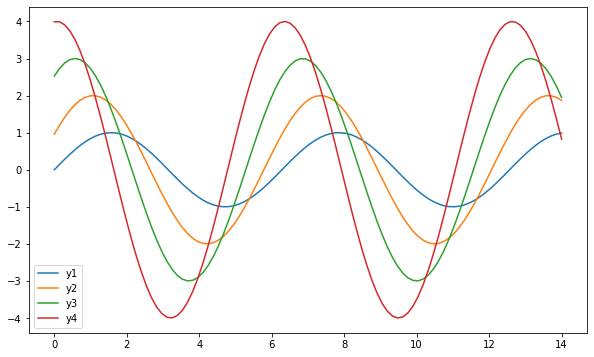

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

x = np.linspace(0, 14, 100)
y1 = np.sin(x)
y2 = 2 * np.sin(x + 0.5)
y3 = 3 * np.sin(x + 1.0)
y4 = 4 * np.sin(x + 1.5)

plt.figure(figsize = (10, 6))
plt.plot(x, y1, label = 'y1')
plt.plot(x, y2, label = 'y2')
plt.plot(x, y3, label = 'y3')
plt.plot(x, y4, label = 'y4')
plt.legend()
plt.show()

**```seaborn```은 ```set_style()```로 그래프의 배경 및 grid 색상을 지정해줄 수 있다**
- "whitegrid"는 일반적인 grid, "darkgrid"로 색감(?)을 줄 수도 ^^
- "white" 또는 "dark"로 설정하면, 선 없이 색상만 설정 가능!

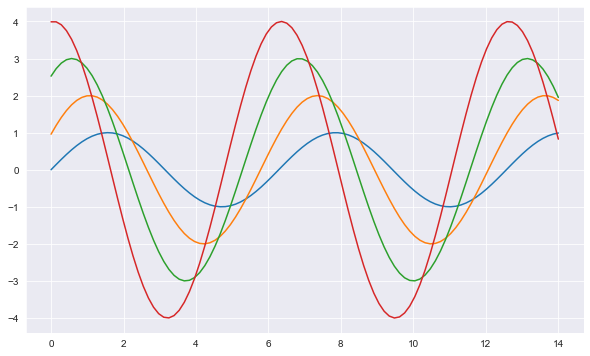

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize = (10, 6))
plt.plot(x, y1, x, y2, x, y3, x, y4)
plt.show()

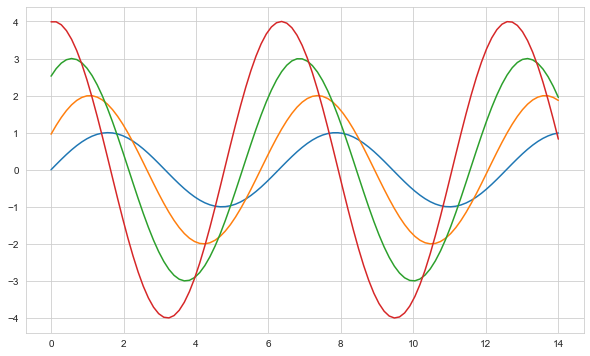

In [ ]:
sns.set_style('whitegrid')

plt.figure(figsize = (10, 6))
plt.plot(x, y1, x, y2, x, y3, x, y4)
plt.show()

**```despine``` 함수를 사용해서 축을 살짝 벌린다(?)**
- 그래프를 (0, 0) 부분을 보면, 살짝 벌어져 있음을 알 수 있다

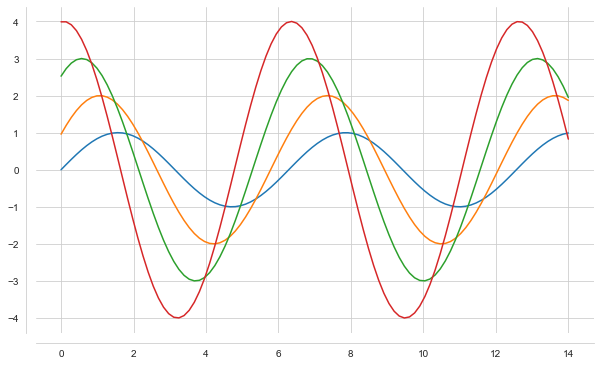

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(x, y1, x, y2, x, y3, x, y4)

sns.despine(offset = 10)

plt.show()

**Tips 데이터 셋을 예제로 사용하여 ```seaborn``` 연습해보기**
- Tips 데이터 셋은 요일별 점심, 저녁, 흡연 여부와 식사 금액과 팁을 정리한 데이터

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


**<참고> Boxplot 코드에 대한 자세한 설명이 나와있는 사이트: https://rfriend.tistory.com/410**

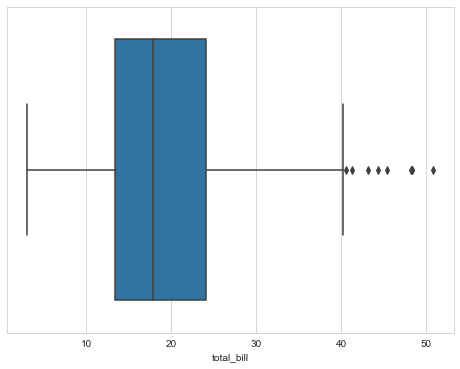

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = tips["total_bill"]) # y = tips["total_bill"] 로 설정하면, 일반적인 '세로' 형태의 상자그림을 그릴 수 있다
plt.show()

**x축을 '요일(day)', y축은 '전체 금액(total_bill)'로 설정하고 boxplot 그리기**

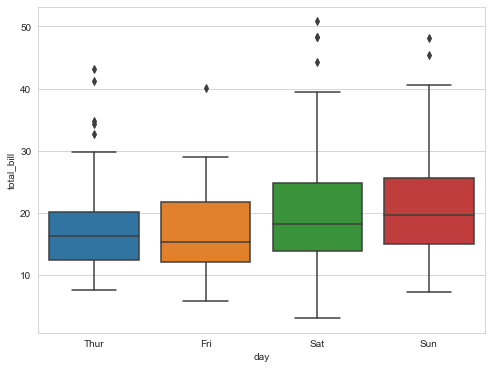

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'day', y = 'total_bill', data = tips)
plt.show()

**```hue``` 인수**
- 두 가지 카테고리 값에 의한 실수 값의 변화를 보기 위한 hue 인수를 제공
- hue 인수에 카테고리 값을 가지는 변수의 이름을 지정하면 카테고리 값에 따라 다르게 시각화

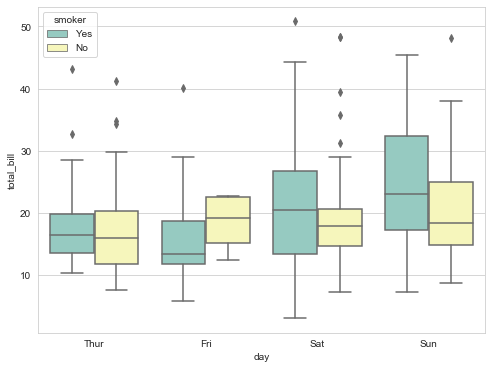

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'day', y = 'total_bill', hue = 'smoker', data = tips, palette = 'Set3')
plt.show()

- ```hue```를 점심/저녁으로 구분

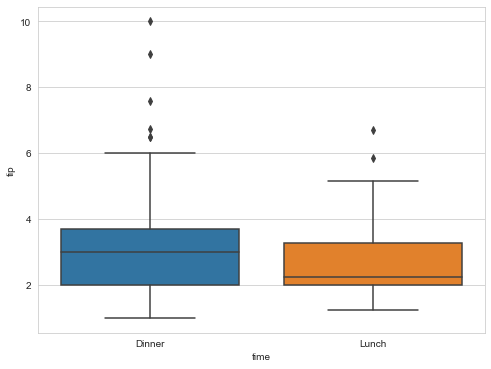

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'time', y = 'tip', data = tips, order = ['Dinner', 'Lunch'])
plt.show()

**```swarmplot()```으로 swarmplot 그려보기**

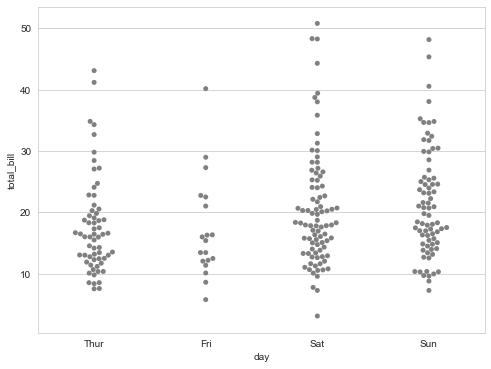

In [ ]:
plt.figure(figsize = (8, 6))
sns.swarmplot(x = 'day', y = 'total_bill', data = tips, color = '0.5')
plt.show()

- 아래와 같이 boxplot과 swarmplot을 동시에 그려줄 수도 있다

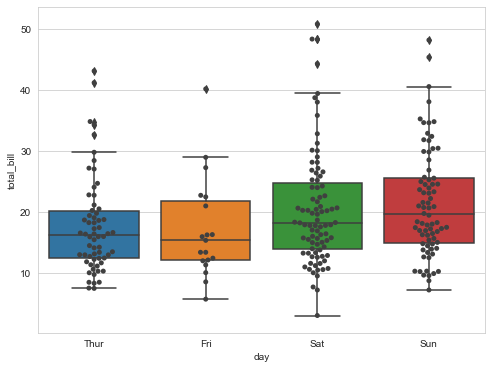

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'day', y = 'total_bill', data = tips)
sns.swarmplot(x = 'day', y = 'total_bill', data = tips, color = '0.25')
plt.show()

**```lmplot()```을 이용하여 lmplot 그려보기**
- 산점도 위에 선형 회귀직선을 같이 그려준다
- Linear Regression 파트에서 많이 사용할 듯(?) 싶다

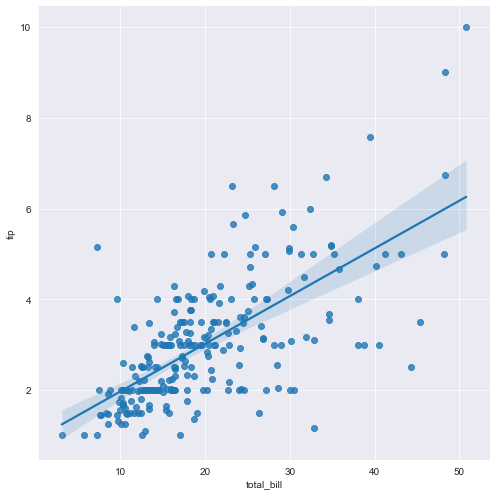

In [ ]:
sns.set_style('darkgrid')
sns.lmplot(x = 'total_bill', y = 'tip', data = tips, height = 7)
plt.show()

- ```hue``` 인수로 'smoker'를 설정해서 lmplot 그리기

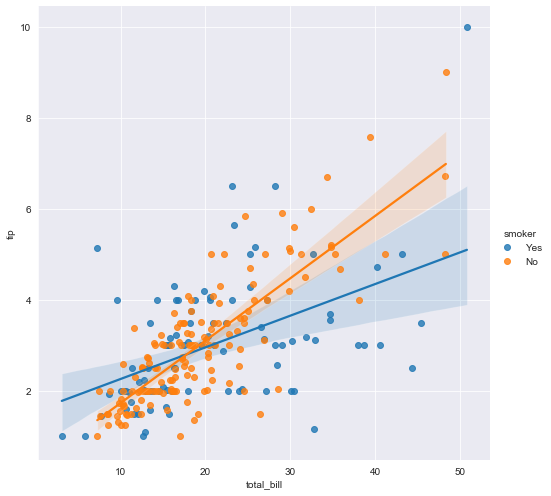

In [ ]:
sns.lmplot(x = 'total_bill', y = 'tip', hue = 'smoker', data = tips, height = 7)
plt.show()

- ```palette``` 인수를 조정해서 그래프에 표시되는 dot 및 line의 색상을 변경해줄 수 있다

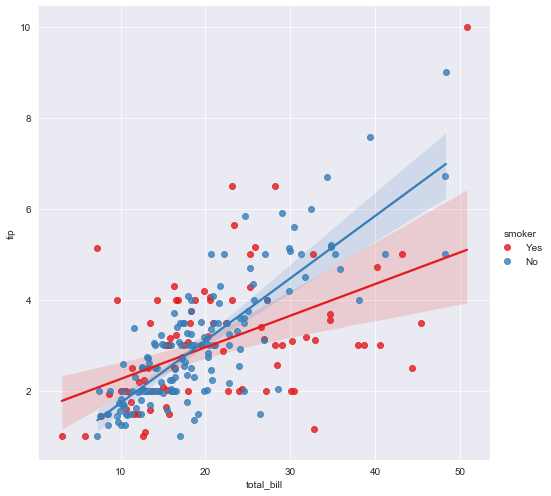

In [ ]:
sns.lmplot(x = "total_bill", y = "tip", hue = "smoker", data = tips, palette = "Set1", height = 7)
plt.show()

**<참고>**
- numpy의 np.random.randint, np.random.rand, np.random.randn에 대한 설명이 나와있는 사이트: https://nittaku.tistory.com/443

In [ ]:
# np.random.rand(): 0 부터 1 사이의 '균일 분포'에서 난수 matrix array 생성
uniform_data = np.random.rand(10, 12)
uniform_data

array([[0.5004866 , 0.09317986, 0.42674523, 0.37042427, 0.85308551,
        0.60532779, 0.01805685, 0.95800075, 0.10125669, 0.46237944,
        0.65104743, 0.43213378],
       [0.25471612, 0.91103641, 0.30265202, 0.2292839 , 0.05516711,
        0.70846954, 0.61859957, 0.2246315 , 0.31869484, 0.20824171,
        0.06032734, 0.16688901],
       [0.49162909, 0.73626662, 0.37767827, 0.20829824, 0.81313332,
        0.09300668, 0.5977966 , 0.54592192, 0.70284839, 0.9921764 ,
        0.15003517, 0.63569026],
       [0.13356767, 0.75966633, 0.04744922, 0.1815465 , 0.93951514,
        0.80631123, 0.09582963, 0.62975981, 0.7717638 , 0.81076558,
        0.4709916 , 0.19524524],
       [0.0442873 , 0.77613234, 0.01613827, 0.87668502, 0.99394794,
        0.15413787, 0.08798884, 0.10921618, 0.12197744, 0.91241033,
        0.03248385, 0.83998824],
       [0.33695541, 0.16145577, 0.02709829, 0.76792121, 0.66150465,
        0.71750024, 0.2922249 , 0.66479749, 0.88386943, 0.53377008,
        0.87447036,

**```heatmap()```으로 heatmap 그리기**

<참고> heatmap()에 대한 자세한 설명이 나와있는 사이트: https://rfriend.tistory.com/419

- x축과 y축에 2개의 범주형 자료의 class 별로 연속형 자료를 집계한 자료를 사용하여, 집계한 값에 비례하여 색깔을 다르게 해서 2차원으로 자료를 시각화

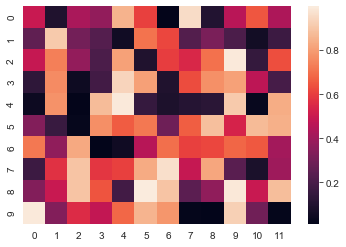

In [ ]:
sns.heatmap(uniform_data)
plt.show()

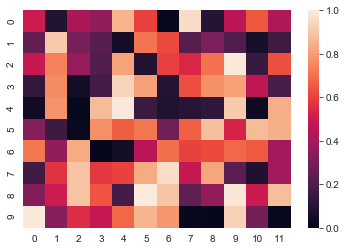

In [ ]:
# vmin과 vmax로 heatmap 오른쪽에 표시되는 색깔 봉의 범위를 지정
sns.heatmap(uniform_data, vmin = 0, vmax = 1)
plt.show()

**연도 및 월별 항공기 승객수를 기록한 데이터를 예시로 heatmap 그려보기**
- 데이터 명은 "flights"이다

In [ ]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [ ]:
# pandas의 pivot()을 이용해서, 여러 분류로 섞인 행 데이터를 열 데이터로 회전!
# 결과적으로 pivot()을 사용해서 간편하게 월별, 연도별로 구분이 가능해졌다
flights = flights.pivot(index = 'month', columns = 'year', values = 'passengers')
flights.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


- ```annot = True```로 설정해서, 각 셀에 숫자를 입력
- ```fmt = 'd'```로 설정해서, '정수' 형태로 숫자를 입력하게끔 지정

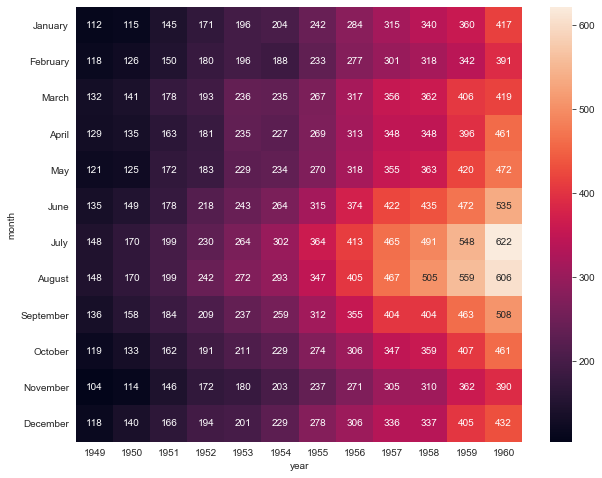

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(flights, annot = True, fmt = 'd')
plt.show()

**<heatmap 결과 해석>**

**결과를 보면, 1959년과 1960년 7월과 8월에 항공기를 이용한 승객들이 많은 것을 알 수 있다**

**역시 옛날에도(?) 여름 휴가철 기간인 7 ~ 8월 사이에 여행을 가는 사람이 많았구나 ㅎㅎ**

**------------------------------------------------(구분선)------------------------------------------------**

**iris 데이터를 예시로 사용하여 pairplot 과 lmplot 그려보기**
- 꽃잎, 꽃받침의 너비와 폭을 가지고 '종(species)'을 구분해보자!

<잠깐!!>

**pairplot이란?**
- 데이터 프레임을 인수로 받아서, grid 형태로 각 데이터 열의 조합에 대해 scatter plot을 그린다. 또한 대각선 영역에는 해당 데이터의 histogram을 그린다!

In [ ]:
sns.set(style = 'ticks')
iris = sns.load_dataset('iris')
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


- ```hue``` 인수에 'species'를 지정해서, '종(species)'별로 시각화
- 추가적으로 ```markers```를 동그라미, 네모, 세모로 지정해서 쉽게 구분가도록 해주었다

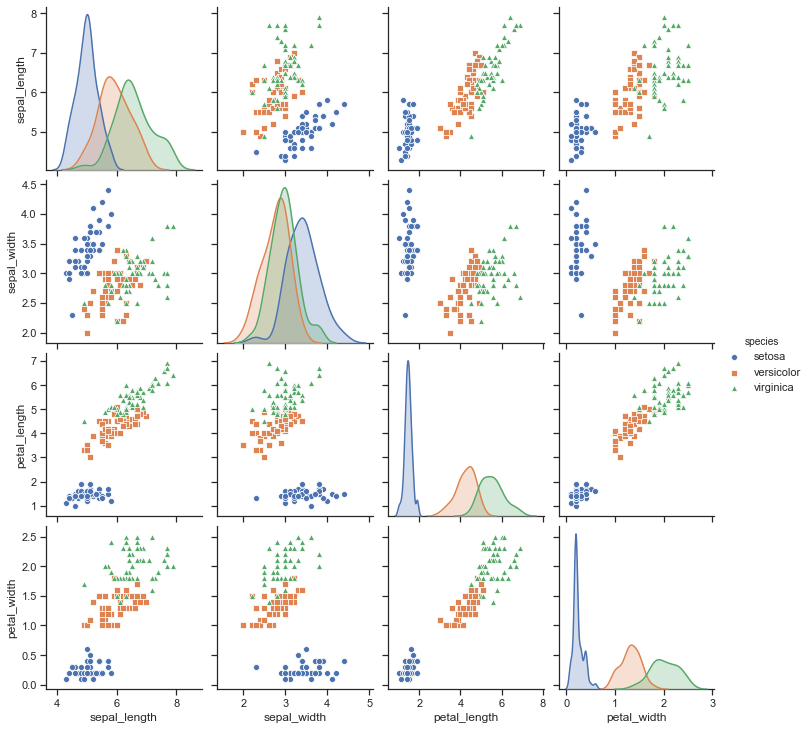

In [ ]:
sns.pairplot(iris, hue = 'species', markers = ['o', 's', '^'])
plt.show()

- ```vars```로 시각화할 변수들을 지정 

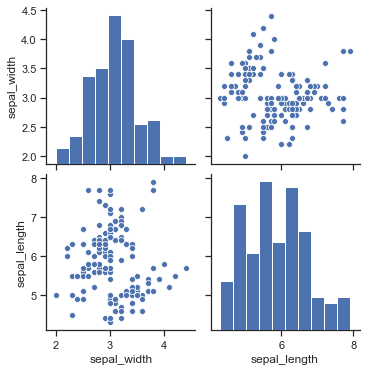

In [ ]:
sns.pairplot(iris, vars = ['sepal_width', 'sepal_length'])
plt.show()

- x축으로 지정할 변수(들)과 y축으로 지정할 변수(들)을 각각 설정할 수도 있다

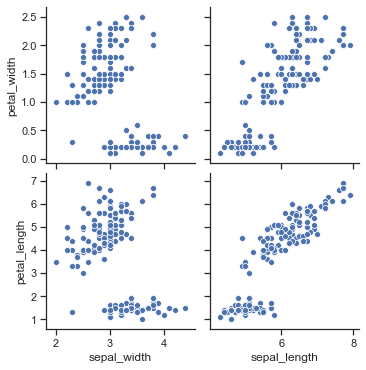

In [ ]:
sns.pairplot(iris, x_vars = ["sepal_width", "sepal_length"], 
             y_vars = ["petal_width", "petal_length"])
plt.show()

**"anscombe" 데이터를 예시로 사용하여 lmplot 그려보기**
- lmplot을 그리면 산점도와 선형 회귀직선을 동시에 보여주기 때문에, 변수들 간의 상관관계를 눈으로 금방 확인해볼 수 있다!

In [ ]:
anscombe = sns.load_dataset('anscombe')
anscombe.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


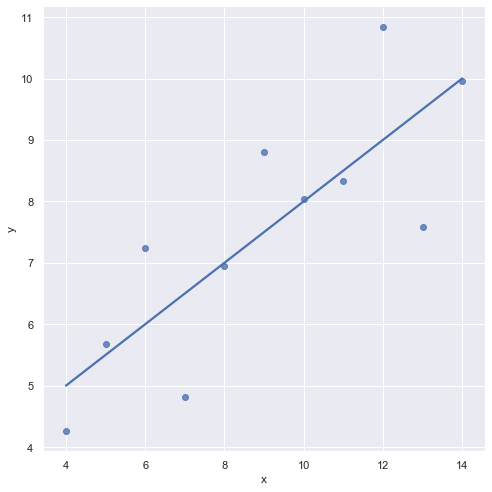

In [ ]:
sns.set_style('darkgrid')

# pandas의 기능 중 하나인 query를 사용하면, 쉽게 데이터 중 일부를 추출할 수 있다
# "dataset == 'I'" 을 설정해서, 1차식 맞춤(?) 데이터가 추출된다
sns.lmplot(x = 'x', y = 'y', data = anscombe.query("dataset == 'I'"),
           ci = None, height = 7)
plt.show()

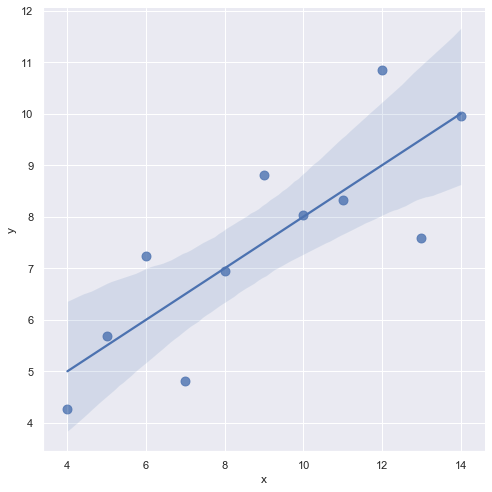

In [ ]:
# ci = None 을 설정해주지 않으면, 아래와 같이 직선 주위에 퍼져있는 면적이 출력된다
sns.lmplot(x = "x", y = "y", data = anscombe.query("dataset == 'I'"),
           scatter_kws = {"s": 80}, height = 7)
plt.show()

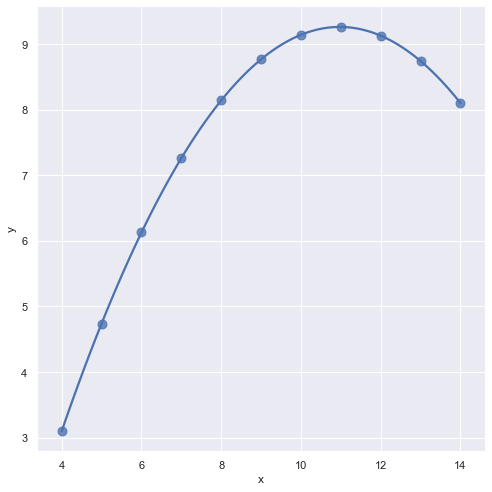

In [ ]:
# order 옵션을 조정해서, 몇 차식으로 estimation 할지 설정할 수 있다
# 여기서는 2차식으로 estimation
sns.lmplot(x = "x", y = "y", data = anscombe.query("dataset == 'II'"), # "dataset == 'II'" 을 설정해서, 2차식 맞춤(?) 데이터가 추출된다
           order = 2, ci = None, scatter_kws = {"s": 80}, height = 7)
plt.show()

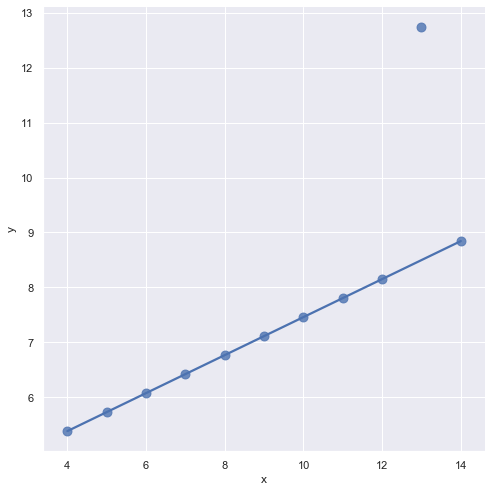

In [ ]:
# robust = True 로 설정해서, 너무 튀는 데이터(이상치)는 무시하도록 만들 수 있다
sns.lmplot(x = "x", y = "y", data = anscombe.query("dataset == 'III'"), # "dataset == 'III'" 을 설정해서, 3차식 맞춤(?) 데이터가 추출된다
           robust = True, ci = None, scatter_kws = {"s": 80}, height = 7)
plt.show()

## 범죄 데이터 시각화하기(Visualization using seaborn)

**본격적으로 시작하기에 앞서, 그래프에 대한 한글 폰트 문제를 해결해주자**
- 아래의 코드를 수행해주면, 그래프에서 한글 폰트로 인해 발생할 수 있는 문제를 해결해줄 수 있다

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import platform
path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~') 

**pairplot을 사용하여 강도, 살인, 폭력 3가지 변수들의 상관관계를 확인**
- 모두 양의 상관관계를 보이고 있다

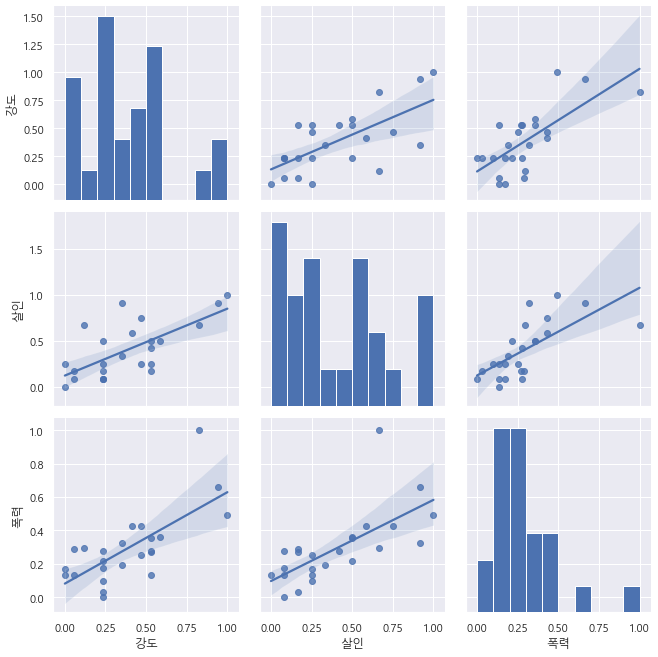

In [ ]:
sns.pairplot(crime_anal_norm, vars = ['강도', '살인', '폭력'], kind = 'reg', height = 3)
plt.show()

**인구수와 CCTV 개수, 그리고 강도와 살인에 대해서도 상관관계를 확인**
- 우선 모두 양의 상관관계를 갖는 것으로 보인다. 하지만 상관계수를 따져볼 때, "인구수"와 "살인"의 상관계수가 그나마 제일 높아보인다 
    - 즉, 인구가 많은 곳이 살인이 비교적 많이 일어난다고 할 수 있겠다(근데 이건 당연한거잖아..?)
- 전체적인 상관계수를 봤을 때, CCTV 개수와 살인의 상관관계가 낮을지 몰라도 CCTV가 없을 때 살인이 많이 일어나는 구간이 존재한다
    - 즉, CCTV 개수를 기준으로 좌측 면에 살인과 강도 건수가 높은 데이터가 보인다

C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


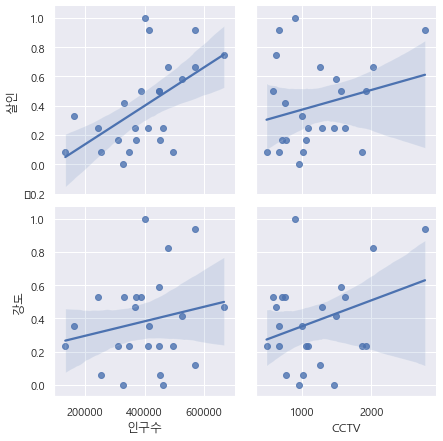

In [ ]:
sns.pairplot(crime_anal_norm, x_vars = ['인구수', 'CCTV'], 
             y_vars = ['살인', '강도'], kind = 'reg', height = 3)
plt.show()

**인구수와 CCTV 개수, 그리고 살인검거율과 폭력검거율의 상관관계를 확인**
- 이번에는 대부분 음의 상관관계가 있는 것으로 나왔다
    - 물론 상관계수 값이 매우 낮아보인다...
- CCTV가 많이 설치되어 있다고 해서, 검거율이 높은 건 아닌 듯 싶다(?)

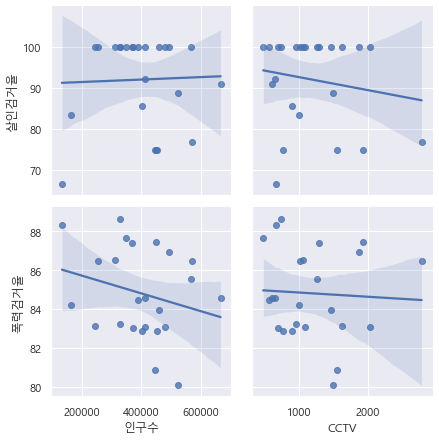

In [ ]:
sns.pairplot(crime_anal_norm, x_vars = ['인구수', 'CCTV'],
             y_vars = ['살인검거율', '폭력검거율'], kind = 'reg', height = 3)
plt.show()

**검거율의 합계인 '검거' 변수의 최고 값을 100으로 한정하고, 그 값을 내림차순 정렬한 후에 ```heatmap```으로 시각화**
- ```heatmap``` 결과를 보면, 절도검거율이 다른 검거율에 비해 현저히 낮은 것을 알 수 있다
- heatmap 아래쪽으로 갈수록 검거율이 낮은데, 강남 3구에 포함되는 *서초구* 도 검거율이 많이 낮다
    - "강남 3구에 포함되는 *서초구* 의 검거율이 왜 이렇게 낮을까?" 하는 의문이 드네...
- 검거율이 전반적으로 우수한 구는 heatmap 위쪽에 위치한 7개의 구(*도봉구, 금천구, 광진구, 동대문구, 용산구, 성동구, 강북구*)이다

In [ ]:
tmp_max = crime_anal_norm['검거'].max()
crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max * 100
crime_anal_norm_sort = crime_anal_norm.sort_values(by = '검거', ascending = False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,348646.0,485,0.318627,100.000000
금천구,0.141210,0.058824,0.083333,0.172426,0.134074,80.794702,100.0,100.0,56.668794,86.465433,255082.0,1015,0.589867,97.997139
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.0,100.0,42.200925,83.047619,372164.0,707,2.034438,96.375820
동대문구,0.204611,0.470588,0.250000,0.314061,0.250887,84.393064,100.0,100.0,41.090358,87.401884,369496.0,1294,1.490147,95.444250
용산구,0.265130,0.529412,0.250000,0.169004,0.133128,89.175258,100.0,100.0,37.700706,83.121951,244203.0,1624,1.346674,94.776790


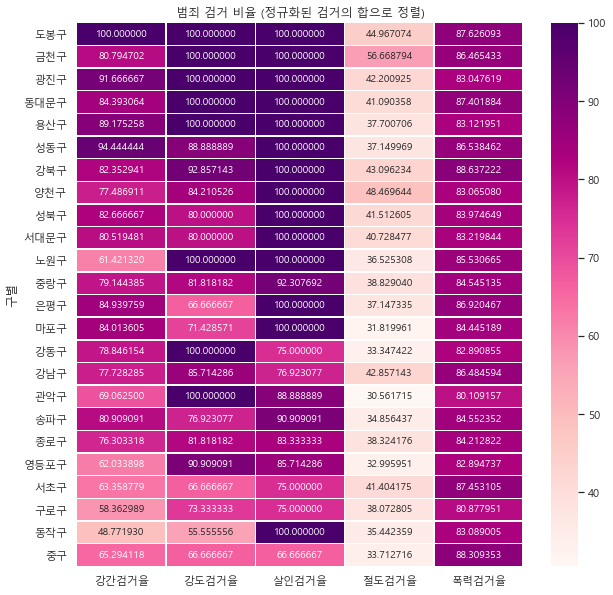

In [ ]:
target_col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

plt.figure(figsize = (10, 10))
sns.heatmap(crime_anal_norm_sort[target_col], annot = True, fmt = 'f',
            linewidths = 0.5, cmap = 'RdPu')
plt.title('범죄 검거 비율 (정규화된 검거의 합으로 정렬)')
plt.show()

**이번에는 발생 건수의 합('범죄')으로 정렬해서 ```heatmap```으로 시각화**
- 발생 건수로 봤을 때는 *강남구, 양천구, 영등포구* 가 범죄 발생 건수가 높다
- 또한 강남 3구인 *송파구* 와 *서초구* 도 범죄 발생 건수가 낮다고는 할 수 없어보인다
    - 이러한 결과로 보았을 때, 과연 강남 3구가 범죄로부터 안전하다고 할 수 있을까??

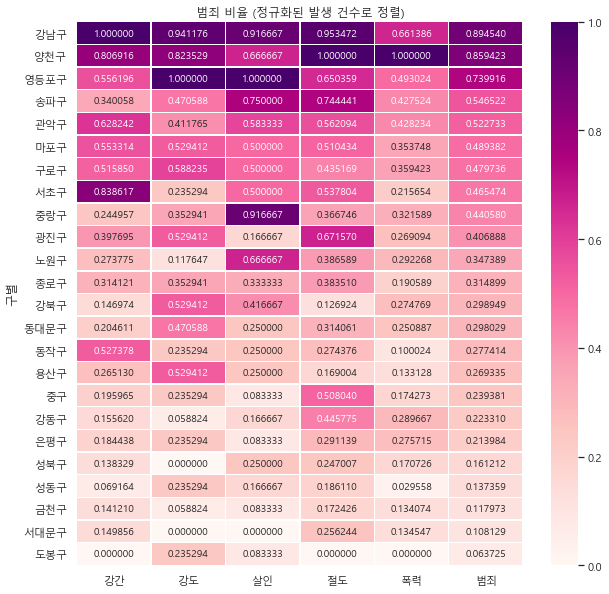

In [ ]:
target_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_anal_norm['범죄'] = crime_anal_norm['범죄'] / 5
crime_anal_norm_sort = crime_anal_norm.sort_values(by = '범죄', ascending = False)

plt.figure(figsize = (10, 10))
sns.heatmap(crime_anal_norm_sort[target_col], annot = True, fmt = 'f', 
            linewidths= 0.5, cmap = 'RdPu')
plt.title('범죄 비율 (정규화된 발생 건수로 정렬)')
plt.show()

**위의 과정들을 거쳐 만들어진 crime_anal_norm 데이터를, csv 파일로 내보내는 코드는 따로 실행하지 않겠다**

**(이미 data 폴더에 해당 데이터가 존재하기 때문)**

In [ ]:
# crime_anal_norm.to_csv("../data/02. crime_in_Seoul_final.csv", sep = ',', encoding = 'utf-8')

## [참고] Folium 기초
- Folium 은 시각화 도구이다
- Folium 라이브러리를 사용하려면, cmd 창을 켜고 ```pip install folium``` 이라는 명령문을 입력해서 설치해야 한다
- Folium 라이브러리를 처음 써보는데, 대박 신기하다... Folium 라이브러리를 잘 사용할 수 있다면, 시각화에 있어서 정말 정말 유용할 것 같다!! ^^

In [ ]:
import folium

**아래와 같이, 그냥 '위도'와 '경도' 정보를 입력해주면 지도를 그려준다!!**

In [ ]:
map_osm = folium.Map(location = [45.5236, -122.6750])
map_osm

- ```zoom_start``` 옵션으로 지도 확대 비율을 지정 가능

In [ ]:
stamen = folium.Map(location = [45.5236, -122.6750], zoom_start = 13)
stamen

- ```tiles``` 옵션으로 지도를 아래와 같이 만들 수도 있다

In [ ]:
stamen = folium.Map(location = [45.5236, -122.6750], 
                    tiles = 'Stamen Toner', zoom_start = 13)
stamen

**지도를 그리고, 그 상태에서 원하는 좌표(위도, 경도)에 ```Marker``` 명령으로 마크 표시하기**
- ```popup``` 옵션으로 표시할 마크의 이름을 지정
- ```Icon``` 명령으로 마크 안에 모양(?)을 무엇으로 할지 지정
    - ex) 여기서는 'cloud'와 'info_sign'으로 지정
    - 즉, "구름" 모양과 information을 의미하는 "i"로 지정
- ```Marker``` 명령으로 마크 표시를 수행해준 뒤, ```add_to``` 명령으로 맨 처음에 만들어놓은 지도에 적용

In [ ]:
map_1 = folium.Map(location = [45.372, -121.6972], zoom_start = 12, 
                   tiles = 'Stamen Terrain')
folium.Marker([45.3288, -121.6625], popup = 'Mt. Hood Meadows', 
              icon = folium.Icon(icon = 'cloud')).add_to(map_1)
folium.Marker([45.3311, -121.7113], popup = 'Timberline Lodge', 
              icon = folium.Icon(color = 'green')).add_to(map_1)
folium.Marker([45.3300, -121.6823], popup = 'Some Other Location', 
              icon = folium.Icon(color = 'red', icon = 'info-sign')).add_to(map_1)
map_1

**```CircleMarker``` 명령으로 반경(radius)과 색상(color)를 지정해서 원 그리기**

In [ ]:
map_2 = folium.Map(location = [45.5236, -122.6750], tiles = 'Stamen Toner', 
                   zoom_start = 13)
folium.Marker([45.5244, -122.6699], popup = 'The Waterfront' ).add_to(map_2)
folium.CircleMarker([45.5215, -122.6261], radius = 50, 
                    popup = 'Laurelhurst Park', color = '#3186cc', 
                    fill_color = '#3186cc', ).add_to(map_2)
map_2

**```RegularPolygonMarker``` 명령으로 반경(radius)과 색상(color)을 지정해서 다각형 그리기**

In [ ]:
map_5 = folium.Map(location = [45.5236, -122.6750], zoom_start = 13)
folium.RegularPolygonMarker([45.5012, -122.6655], 
                            popup = 'Ross Island Bridge', fill_color = '#132b5e', 
                            number_of_sides = 3, radius = 10).add_to(map_5)
folium.RegularPolygonMarker([45.5132, -122.6708], 
                            popup = 'Hawthorne Bridge', fill_color = '#45647d', 
                            number_of_sides = 4, radius = 10).add_to(map_5)
folium.RegularPolygonMarker([45.5275, -122.6692], 
                            popup = 'Steel Bridge', fill_color = '#769d96', 
                            number_of_sides = 6, radius = 10).add_to(map_5)
folium.RegularPolygonMarker([45.5318, -122.6745], 
                            popup = 'Broadway Bridge', fill_color = '#769d96', 
                            number_of_sides = 8, radius = 10).add_to(map_5)
map_5

**<"02. folium_US_Unemployment_Oct2012.csv" 데이터를 사용한 Folium 실습>**
- 위 데이터는 "2012년 10월 기준 미국의 주별 실업률 데이터"이다

In [ ]:
import folium
import pandas as pd

In [ ]:
state_unemployment = "../data/02. folium_US_Unemployment_Oct2012.csv"
state_data = pd.read_csv(state_unemployment)
state_data.head()

,State,Unemployment
0,AL,7.1
1,AK,6.8
2,AZ,8.1
3,AR,7.2
4,CA,10.1


**"02. folium_us-states.json" 이라는 json 파일을 불러와서 지도 시각화**
- folium에서 ```choropleth``` 명령을 사용해서 *json 파일과 지도에 표현하고 싶은 데이터* 를 입력
- ```key_on``` 옵션으로 *지도의 id* 를 입력
    - 단, 여기서 *지도의 id*가 서로 중복되지 않아야 한다!!
- 결과적으로, 지도에 실업률이 colormap으로 표현된다

<참고>
**json 파일 설명**
- id로 '주별 고유 ID', 그리고 주 이름 등의 '좌표'가 있는 데이터
- 위도 및 경도 좌표가 입력되어 있어서, 그걸 따라서 선을 그리면 '주 경계선'이 된다

In [ ]:
state_geo = "../data/02. folium_us-states.json"

map = folium.Map(location = [40, -98], zoom_start = 4)
map.choropleth(geo_data = state_geo, data = state_data,
               columns = ['State', 'Unemployment'],
               key_on = 'feature.id',
               fill_color = 'YlGn',
               legend_name = 'Unemployment Rate (%)')
map

C:\Users\Playdata\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**여기까지 해서 Folium에 대한 간략한 설명은 마무으리~~**

**아래부터는 Folium 라이브러리를 사용해서 서울시 범죄율에 대한 지도를 시각화 해보겠다!**

## 서울시 범죄율에 대한 지도 시각화

In [ ]:
import json
geo_path = "../data/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding = 'utf-8'))

**서울시의 중심의 위도 및 경도 정보를 입력하고 경계선 그리기**
- colormap 은 살인 발생 건수('살인')로 지정!!
- 시각화 결과를 살펴보면, 강남 3구가 살인 사건으로부터 안전하다고 볼 수 없을 것 같다...

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['살인'],
               columns = [crime_anal_norm.index, crime_anal_norm['살인']],
               fill_color = 'PuRd', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')
map

- 이번에는 colormap 을 강간 발생 건수('강간')로 지정!!
- 마찬가지로 시각화 결과를 살펴보면, 강남 3구가 강간 사건으로부터 안전하다고 볼 수 없을 것 같다...

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['강간'],
               columns = [crime_anal_norm.index, crime_anal_norm['강간']],
               fill_color = 'PuRd', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')
map

- 이번에는 colormap 을 범죄 발생 건수('범죄')로 지정!!
    - '범죄'는 5대 범죄(강간, 강도, 살인, 절도, 폭력)를 모두 포함한 것을 의미
- 마찬가지로 시각화 결과를 살펴보면, 강남 3구가 범죄 사건으로부터 안전하다고 볼 수 없을 것 같다...

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['범죄'],
               columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
               fill_color = 'PuRd', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')
map

- 위에서는 colormap 시각화를 범죄 발생 건수('범죄') 기준으로 수행했다
- 하지만 더 정확한 판단을 위해, 각 구별 인구수를 고려해서 '인구 대비 범죄 발생 비율'을 알아보았다
- 앞서 인구수를 고려하지 않은 경우에 비해, '중구'와 '종로구'의 범죄율이 눈에 띄게 높아졌음을 볼 수 있다
    - 이러한 결과가 나온 이유는 아마도 인구수는 적으나, 주변에 유명 관광지들이 많기 때문이 아닐까??

In [ ]:
tmp_criminal = crime_anal_norm['범죄'] / crime_anal_norm['인구수'] * 100

map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = tmp_criminal,
               columns = [tmp_criminal.index, tmp_criminal],
               fill_color = 'PuRd', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')
map

**'인구 대비 범죄 발생 비율'을 확인해봤으니, 이제 '검거율'을 시각화 해보자!**
- 강남 3구인 '강남구', '서초구', '송파구'의 검거율이 그렇게 높아 보이지는 않는다

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11, 
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['검거'],
               columns = [crime_anal_norm.index, crime_anal_norm['검거']],
               fill_color = 'YlGnBu', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')
map

**시각화 결과를 다 보고나서 드는 의문점... 2장을 시작할 때 언급한 뉴스 기사는 무슨 근거로 작성된 것일까??**

## 서울시 경찰서별 검거율과 구별 범죄 발생율을 동시에 시각화하기
- 앞서 수행했던 시각화 작업들을 한 번에 해준다면, 더욱 더 효과적일 것이다

In [ ]:
# 위도 및 경도 좌표를 'lat'과 'lng'라는 변수로 만들어주기
crime_anal_raw['lat'] = station_lat
crime_anal_raw['lng'] = station_lng

col = ['살인 검거', '강도 검거', '강간 검거', '절도 검거', '폭력 검거']

# 각 범죄별 검거 건수를 해당 범죄의 최대 검거 건수로 나눠준다
tmp = crime_anal_raw[col] / crime_anal_raw[col].max()

# axis = 1 로 설정해서, 각 경찰서별로 검거율을 합해준다
crime_anal_raw['검거'] = np.sum(tmp, axis = 1)

crime_anal_raw.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564785,126.966776,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


**먼저 각 경찰서들의 위치 확인!!**

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

# 각 경찰서의 위도 및 경도 정보를 이용해서, folium 으로 시각화
for n in crime_anal_raw.index:
    folium.Marker([crime_anal_raw['lat'][n], 
                   crime_anal_raw['lng'][n]]).add_to(map)
    
map

**```CircleMarker``` 명령에서 '검거'에 정당한 값(10)을 곱해서 원 넓이를 지정하고, '경찰서의 검거율'을 원의 넓이로 표현**
- 넓은 원일수록 검거율이 높다는 것을 의미한다!

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]], 
                        radius = crime_anal_raw['검거'][n] * 10, 
                        color = '#3186cc', fill_color = '#3186cc', fill = True).add_to(map)
    
map

**이제 붉은색으로 '범죄 발생 건수'를 위에서 시각화한 지도에 추가해주겠다**
- '각 경찰서의 검거율'과 '범죄 발생 건수'를 동시에 시각화하여 보기 위해서!!

In [ ]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

# 1. '범죄 발생 건수'를 지도에 시각화
map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['범죄'],
               columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
               fill_color = 'PuRd', # 'PuRd', 'YlGnBu'
               key_on = 'feature.id')

# 2. 각 경찰서의 검거율을 원의 넓이로 표현해서 시각화
for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]], 
                        radius = crime_anal_raw['검거'][n] * 10, 
                        color = '#3186cc', fill_color = '#3186cc', fill = True).add_to(map)
    
map

C:\Users\Playdata\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**<최종 시각화 결과 해석>**
- 지도에서 범죄가 많이 발생할수록 붉은색이고, 원의 크기가 넓을수록 해당 경찰서의 검거율이 높다는 의미이다
- 결과를 자세히 살펴보면, 서울 서부는 범죄가 많이 발생하지만 검거율이 비교적 높은 편이다
- 반면, 서울 북부는 범죄 발생 건수가 적고 검거율 또한 낮다
- 이제 우리가 증명해보려 했던 "강남 3구는 범죄로부터 정말 안전할까?"라는 가설에 대해 확인해보겠다
    - 강남 3구(강남구, 서초구, 송파구)에 각종 유흥업소들이 많이 밀집되어 있어서 범죄 발생 건수가 높은 편이다
    - 그에 비해 강남 3구의 검거율이 매우 좋아보이지는 않는다
    - 이러한 결과를 보았을 때, 과연 강남 3구가 정말로 범죄로부터 안전한지에 대한 의문이 남는다...